In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# FOR .py FILE!

# **Dependencies and imports**

This can take a minute...

In [2]:
# https://github.com/robert-lieck/rldurham/tree/main - rldurham source

# !pip install swig
# !pip install --upgrade rldurham

# !pip install wandb
# !pip install torchinfo
# !pip install nbformat

In [3]:
import math
import random
import copy
import time
import os

import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch.distributions as D
from torch.distributions.transforms import TanhTransform

import rldurham as rld

import wandb
# os.environ["WANDB_API_KEY"] = "x" # TODO remove
wandb.login()

# from torchinfo import summary

/Users/Subspace_Explorer/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
wandb: Currently logged in as: theo-farrell99 (theo-farrell99-durham-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [4]:
# checkpoint setup
CHECKPOINT_DIR = "./checkpoints"
CHECKPOINT_FILE = os.path.join(CHECKPOINT_DIR, "training_checkpoint.pth")
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# **RL agent**

In [5]:
MAX_TIMESTEPS = 2000 # [DONT CHANGE]
SOURCE_ID = '' # mac, ncc, colab -> for personal id in wandb


if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
else:
    DEVICE = torch.device("cpu")
DEVICE

device(type='mps')

## helper fns

In [6]:
# checkpoint helper fns

def save_checkpoint(state, filename=CHECKPOINT_FILE):
    """Saves the current training state."""
    print(f"Saving checkpoint to {filename}...")
    torch.save(state, filename)
    # Optionally, save replay buffer separately if it's very large
    # np.savez_compressed(filename + "_buffer.npz",
    #                     state=state['replay_buffer']['state'],
    #                     action=state['replay_buffer']['action'],
    #                     next_state=state['replay_buffer']['next_state'],
    #                     reward=state['replay_buffer']['reward'],
    #                     not_done=state['replay_buffer']['not_done'])
    print("Checkpoint saved.")

def load_checkpoint(filename=CHECKPOINT_FILE):
    """Loads training state from a checkpoint file."""
    if os.path.isfile(filename):
        print(f"Loading checkpoint from {filename}...")
        checkpoint = torch.load(filename)
        # Optionally load large replay buffer separately
        # if os.path.isfile(filename + "_buffer.npz"):
        #     print("Loading replay buffer data...")
        #     buffer_data = np.load(filename + "_buffer.npz")
        #     checkpoint['replay_buffer_data'] = buffer_data
        # else:
        #     print("Warning: Replay buffer data file not found.")
        #     checkpoint['replay_buffer_data'] = None # Indicate buffer data is missing
        print("Checkpoint loaded.")
        return checkpoint
    else:
        print(f"No checkpoint found at {filename}, starting from scratch.")
        return None

In [7]:
# HELPERs
# for https://github.com/ArijusLengvenis/bipedal-walker-dreamer/blob/main/dreamer_bipedal_walker_code.ipynb

def train_on_environment(actor, env, grad_step_class, replay_buffer, max_timesteps,
    state, batch_size, total_steps, sequence_length,
    use_intrinsic_reward=False, last_dreamer_test_loss=0.0, intrinsic_r_scale=0.0,
    ):
    '''
    abstracted training loop function for both real & dreamer environments to use

    the real environment will always have MAX_TIMESTEPS as the max_timesteps value,
    while the dreamer enviroment might have less timesteps TODO could it also have MAX_TIMESTEPS?
    '''
    ep_timesteps = 0
    ep_reward = 0

    state_dim = actor.state_dim
    act_dim = actor.action_dim
    input_dim = state_dim + act_dim + state_dim + 1 + 1 # state, action, next_state, reward, done
    
    # save start sequence for the dreamer model
    input_buffer = torch.empty((0, input_dim), dtype=torch.float32).to(DEVICE)

    # initial state float32 for mps
    state = state.astype(np.float32)

    for t in range(max_timesteps): 
        total_steps += 1
        # select action and step the env
        action = actor.select_action(state)
        step = env.step(action)

        # handle different return formats
        if len(step) == 5:
            next_state, reward, term, tr, info = step
            done = term or tr
        else:
            next_state, reward, done, info = step

        # float32 before processing/storing
        next_state = next_state.astype(np.float32)
        reward = float(reward)
        done = float(done) # keep done as float for consistency

        ep_timesteps += 1
        ep_reward += reward # extrinsic reward in ep_reward

        if max_timesteps == MAX_TIMESTEPS: # TODO could we be in dreamer for this?
            if reward == -100.0:
                reward = -10.0 # bipedal walker does -100 for hitting floor, so -10 might make it more stable
            else:
                reward *= 2 # TODO why might this be justified? (encouraging forward motion?)

            combined_r = reward
            if use_intrinsic_reward and last_dreamer_test_loss > 0:
                r_intr = intrinsic_r_scale * last_dreamer_test_loss
                combined_r += r_intr
                wandb.log({"Intrinsic Reward Added": r_intrinsic}, commit=False) # log to wandb (commit = false lets us log things later in the ep)

            replay_buffer.add(state, action, next_state, combined_r, done)
        else:
            if t == sequence_length:
                for row in input_buffer.cpu().numpy():
                    replay_buffer.add(
                        row[:state_dim], # state row[:24]
                        row[state_dim:state_dim+act_dim], # action row[24:28]
                        row[state_dim+act_dim:state_dim+act_dim+state_dim], # next_state row[28:52]
                        row[-2], # reward row[52]
                        row[-1] # done row[53]
                    )
                # add the last step to the buffer
                replay_buffer.add(state, action, next_state, reward, done)
            elif t > sequence_length:
                # add last step directly
                replay_buffer.add(state, action, next_state, reward, done)
            # don't store if simulation ends without reaching the sequence length
        
        if t < sequence_length: # store in input buffer for dreamer start seq
            combined_np = np.concatenate((
                state, 
                action.astype(np.float32), 
                next_state, 
                np.array([reward], dtype=np.float32), 
                np.array([done], dtype=np.float32)
            ), axis=0)
            combined = torch.tensor(combined_np, dtype=torch.float32).unsqueeze(0).to(DEVICE)
            input_buffer = torch.cat([input_buffer, combined], axis=0)
    
        state = next_state
        
        if total_steps >= batch_size: # do 1 training update using 1 batch from buffer if enough
            # train the agent using experiences from the real environment
            grad_step_class.take_gradient_step(replay_buffer, total_steps, batch_size)
    
        if done: # break if finished
            break

    # only return extrinsic to eval based on that
    if sequence_length > 0: # TODO - this means...? 
        return ep_timesteps, ep_reward, input_buffer.to(torch.float32), info
    return ep_timesteps, ep_reward, None, info


# test loop for agent on environment
# def simulate_on_environment(actor, env, max_timesteps, state):
#     ep_timesteps = 0
#     ep_reward = 0
#     for t in range(max_timesteps):
#         action = actor.select_action(state)
#         step = env.step(action)
#         if len(step) == 5:
#             next_state, reward, term, tr, _ = step
#             done = term or tr
#         else:
#             next_state, reward, done, _ = step
#         ep_timesteps += 1
    
#         state = next_state
#         ep_reward += reward
    
#         if done or t == max_timesteps - 1:
#             break
#     return ep_timesteps, ep_reward


In [8]:
# https://github.com/ArijusLengvenis/bipedal-walker-dreamer/blob/main/dreamer_bipedal_walker_code.ipynb

# generate value array from replay buffer
def retrieve_from_replay_buffer(replay_buffer, ptr):
    '''
    returns (state, action, reward, done, next_state)
    '''
    return np.concatenate((
            replay_buffer.state[ptr:replay_buffer.ptr],
            replay_buffer.action[ptr:replay_buffer.ptr],
            replay_buffer.reward[ptr:replay_buffer.ptr],
            1. - replay_buffer.not_done[ptr:replay_buffer.ptr],
            replay_buffer.next_state[ptr:replay_buffer.ptr],                
        ), 
        axis = 1 # along the columns (so each row is a memory)
    )

# function to create sequences with a given window size and step size
def create_sequences(memories, window_size, step_size):
    '''
    Function to create sequences of memories from the replay buffer.

    Each sequence is of length window_size and each spaced apart by step_size
    '''
    n_memories = memories.shape[0] # just the number of time steps currently in the buffer

    # calc number of seq (of len window_size) we can create from mems available  
    n_sequences = math.floor((n_memories - window_size) / step_size) + 1 # +1 because indices start at 0

    sequences = np.zeros((n_sequences, window_size, memories.shape[1]))
    for i in range(n_sequences):
        start_idx = i * step_size # idx to start seq from
        sequences[i, :] = memories[start_idx:start_idx + window_size, :] # grab seq of memories window_size long from start_idx
    return sequences

def gen_test_train_seq(replay_buffer, train_set, test_set, train_split, window_size, step_size, ptr):
    '''
    Function to split train and test data
    '''
    memories = retrieve_from_replay_buffer(replay_buffer, ptr)
    try:
        memory_sequences = create_sequences(memories, window_size, step_size)
        n_sequences = memory_sequences.shape[0]
    except: # TODO How might this go wrong? not enough new data to create a sequence?
        return train_set, test_set

    # shuffle the sequences & split
    indices = np.arange(n_sequences)
    np.random.shuffle(indices)

    split = int(train_split * n_sequences) # get split point 
    train_indices = indices[:split]
    test_indices = indices[split:]

    if train_set is None: # if this is first train/test set, create the sets
        return memory_sequences[train_indices, :], memory_sequences[test_indices, :]
    # else just add to existing sets
    return np.concatenate((train_set, memory_sequences[train_indices, :]), axis=0), np.concatenate((test_set, memory_sequences[test_indices, :]), axis=0)


In [9]:
def get_dreamer_eps(dreamer_avg_loss, score_threshold):
    '''
    Get number of dreamed episdoes the agent should run on the dreamer model.

    Only use dreamer for training if it's sufficiently accurate model of env.

    Note - score_threshold is between 0 and 1.

    Disclaimer - calculation from https://github.com/ArijusLengvenis/bipedal-walker-dreamer/blob/main/dreamer_bipedal_walker_code.ipynb
    '''
    max_dreamer_it = 10 # a perfect dreamer has this many eps

    if dreamer_avg_loss >= score_threshold:
        return 0
    else:
        norm_score = dreamer_avg_loss/score_threshold # normalise score relative to threshold
        inv_score = 1 - norm_score # invert so that closer to 1 ==> dreamer score much better than threshold
        sq_score = inv_score**2 # square so that num iter increases quadratically as accuracy improves
        return int(max_dreamer_it * sq_score) # scale so that max iterations is 10 (when dreamer very accurate)


## replay buffer

In [10]:
class EREReplayBuffer(object):
    '''
    implementation - https://github.com/ArijusLengvenis/bipedal-walker-dreamer/blob/main/dreamer_bipedal_walker_code.ipynb
    An ERE buffer is implemented to improve sample efficiency, 
        for which the paper can be found here: https://arxiv.org/abs/1906.04009

    Rationale:
    - actions from early in training are likely v different to optimal, so want to prioritise recent ones so we're not constantly learning from crap ones
    - as time goes on, they get more similar so annealing eta allows uniform sampling later on
    '''
    def __init__(self, state_dim, action_dim, T, max_size, eta, cmin):
        self.max_size, self.ptr, self.size, self.rollover = max_size, 0, 0, False
        self.eta0 = eta
        self.cmin = cmin
        self.c_list = []
        self.index = []
        self.T = T

        self.reward = np.empty((max_size, 1), dtype=np.float32) # float32 for mps
        self.state = np.empty((max_size, state_dim), dtype=np.float32)
        self.action = np.empty((max_size, action_dim), dtype=np.float32)
        self.not_done = np.empty((max_size, 1), dtype=np.float32)
        self.next_state = np.empty((max_size, state_dim), dtype=np.float32)
        
    def sample(self, batch_size, t):
        # update eta value for current timestep
        eta = self.eta_anneal(t)

        index = np.array([self._get_index(eta, k, batch_size) for k in range(batch_size)])

        r = torch.tensor(self.reward[index], dtype=torch.float32).to(DEVICE)
        s = torch.tensor(self.state[index], dtype=torch.float32).to(DEVICE)
        ns = torch.tensor(self.next_state[index], dtype=torch.float32).to(DEVICE)
        a = torch.tensor(self.action[index], dtype=torch.float32).to(DEVICE)
        nd = torch.tensor(self.not_done[index], dtype=torch.float32).to(DEVICE)
        
        return s, a, ns, r, nd
    
    def _get_index(self, eta, k, batch_size):
        c_calc = self.size * eta ** (k * 1000 / batch_size)
        ck = c_calc if c_calc > self.cmin else self.size

        if not self.rollover: # if we're not overwriting yet, ...
            return np.random.randint(self.size - ck, self.size)
        
        return np.random.randint(self.ptr + self.size - ck, self.ptr + self.size) % self.size

    def eta_anneal(self, t):
        # eta anneals over time --> 1, which reduces emphasis on recent experiences over time
        return min(1.0, self.eta0 + (1 - self.eta0) * t / self.T)
 
    def add(self, state, action, next_state, reward, done):
        # Add experience to replay buffer 
        self.state[self.ptr] = state.astype(np.float32)
        self.action[self.ptr] = action.astype(np.float32)
        self.next_state[self.ptr] = next_state.astype(np.float32)
        self.reward[self.ptr] = float(reward)
        self.not_done[self.ptr] = 1. - float(done)

        self.ptr += 1
        self.ptr %= self.max_size

        # increase size counter until full, then start overwriting (rollover)
        if self.max_size > self.size + 1:
          self.size += 1
        else:
          self.size = self.max_size
          self.rollover = True


## agent

**dreamer**

In [11]:
class DreamerAgent(nn.Module):
    '''
    Dreamer agent.
    Uses a transformer model to predict the next state, reward and done signal given the current (state, action, reward, done)

    Acknowledgements:
    - implementation based on https://github.com/ArijusLengvenis/bipedal-walker-dreamer/blob/main/dreamer_bipedal_walker_code.ipynb
    - (from implementation designer) key ideas and concepts for the auto-regressive transformer design stem from this paper: https://arxiv.org/abs/2202.09481
    '''
    def __init__(self, state_dim, action_dim, hidden_dim, seq_len, num_layers, num_heads, dropout_prob, lr):
        super().__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.input_dim = state_dim + action_dim + 2 # (state, action, reward, done)
        self.target_dim = self.state_dim + self.action_dim # (state, action)
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.dropout_prob = dropout_prob

        self.mse_loss = nn.MSELoss()
        self.ce_loss = nn.CrossEntropyLoss()
        self.bce_loss = nn.BCEWithLogitsLoss()
        
        self.input_fc = nn.Linear(self.input_dim, hidden_dim).to(DEVICE)
        self.target_fc = nn.Linear(self.target_dim, hidden_dim).to(DEVICE)
        self.transformer = nn.Transformer( # uses transformer model!
            hidden_dim, 
            num_layers, 
            num_heads, 
            dropout=dropout_prob,
            activation=F.gelu,
            batch_first=True
        ).to(DEVICE)
        self.output_next_state = nn.Linear(hidden_dim + self.target_dim, state_dim).to(DEVICE)
        self.output_reward = nn.Linear(hidden_dim + self.target_dim, 1).to(DEVICE)
        self.output_done = nn.Linear(hidden_dim + self.target_dim, 1).to(DEVICE)
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        
    # separate out the ground truth variables and compare against predictions
    def loss_fn(self, output_next_state, output_reward, output_done, ground_truth):
        reward, done, next_state = torch.split(ground_truth, [1, 1, self.state_dim], dim=-1)
        loss = self.mse_loss(output_next_state[:, -1], next_state)
        loss += self.mse_loss(output_reward[:, -1], reward)
        # loss += self.ce_loss(output_done[:, -1], done)
        loss += self.bce_loss(output_done[:, -1], done.float())
        return loss

    def forward(self, input_tensor):
        # separate the input and target tensors
        target = input_tensor[:, -1, :self.target_dim].unsqueeze(1)
        encoded_target = self.target_fc(target)
        encoded_input = self.input_fc(input_tensor[:, :-1, :self.input_dim])

        # pass these into the transformer
        encoded_output = self.transformer(encoded_input, encoded_target)

        # decode the densely connected output
        output_next_state = self.output_next_state(torch.cat([encoded_output, target], axis=2))
        output_reward = self.output_reward(torch.cat([encoded_output, target], axis=2))
        output_done = self.output_done(torch.cat([encoded_output, target], axis=2)) # don't need sigmoid because nn.CrossEntropy already does it? (or can use BCE loss after sigmoid)
        # output_done = torch.sigmoid(self.output_done(torch.cat([encoded_output, target], axis=2)))
        return output_next_state, output_reward, output_done
    
    def predict(self, input_tensor, target_tensor):
        # separate the input and target tensors
        encoded_target = self.target_fc(target_tensor)
        encoded_input = self.input_fc(input_tensor)

        # pass these into the transformer
        encoded_output = self.transformer(encoded_input, encoded_target)

        # decode the densely connected output
        output_next_state = self.output_next_state(torch.cat([encoded_output, target_tensor], axis=1))
        output_reward = self.output_reward(torch.cat([encoded_output, target_tensor], axis=1))
        output_done = torch.sigmoid(self.output_done(torch.cat([encoded_output, target_tensor], axis=1)))
        return output_next_state, output_reward, output_done

    # transformer training loop
    # sequences shape: (batch, sequence, features)
    def train_dreamer(self, sequences, epochs, batch_size=256):
        print("Training Dreamer...")
        inputs = torch.tensor(sequences, dtype=torch.float).to(DEVICE)
        
        train_dataset = TensorDataset(inputs)
        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        self.transformer.train()

        for epoch in range(epochs):
            running_loss = 0.0
            for i, input_batch in enumerate(train_dataloader):
                input_batch = input_batch[0].to(DEVICE)
                self.optimizer.zero_grad()
                output_next_state, output_reward, output_done = self.forward(input_batch)
                loss = self.loss_fn(output_next_state, output_reward, output_done, input_batch[:, -1, self.target_dim:])
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item()
            print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch + 1, epochs, running_loss / len(train_dataloader)))

    # transformer testing loop
    def test_dreamer(self, sequences, batch_size=64):
        print("Testing Dreamer...")
        inputs = torch.tensor(sequences, dtype=torch.float).to(DEVICE)
        
        test_dataset = TensorDataset(inputs)
        test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

        self.transformer.eval()

        with torch.no_grad():
            running_loss = 0.0
            for i, input_batch in enumerate(test_dataloader):
                input_batch = input_batch[0].to(DEVICE)
                output_next_state, output_reward, output_done = self.forward(input_batch)
                loss = self.loss_fn(output_next_state, output_reward, output_done, input_batch[:, -1, self.target_dim:])
                running_loss += loss.item()
            print('Test Loss: {:.4f}'.format(running_loss / len(test_dataloader)))
        return running_loss / len(test_dataloader)
    
    def step(self, action):
        act = torch.tensor(np.array([action]), dtype=torch.float32).to(DEVICE)
        self.actions = torch.cat([self.actions, act], axis=0)

        input_sequence = torch.cat([self.states[:-1], self.actions[:-1], self.rewards, self.dones], axis=1).to(torch.float32)
        target = torch.cat([self.states[-1], self.actions[-1]], axis=0).unsqueeze(0).to(torch.float32)
        
        with torch.no_grad():
            next_state, reward, done = self.predict(input_sequence, target)
            next_state = next_state.to(torch.float32)
            reward = reward.to(torch.float32)
            done = (done >= 0.6).to(torch.float32) # bias towards not done to avoid false positives

            self.states = torch.cat([self.states, next_state], axis=0)
            self.rewards = torch.cat([self.rewards, reward], axis=0)
            self.dones = torch.cat([self.dones, done], axis=0)
            
            # trim sequences
            if self.states.shape[0] > self.seq_len:
                self.states = self.states[1:]
                self.rewards = self.rewards[1:]
                self.dones = self.dones[1:]
            if self.actions.shape[0] > self.seq_len - 1: # action seq shorter
                self.actions = self.actions[1:]
        
        return next_state.squeeze(0).cpu().numpy(), reward.cpu().item(), done.cpu().item(), None


**actor-critic**

In [12]:
# LOSS
# https://github.com/ArijusLengvenis/bipedal-walker-dreamer/blob/main/dreamer_bipedal_walker_code.ipynb

def quantile_huber_loss(quantiles, samples, sum_over_quantiles = False):
    '''
    From TQC (see paper p3)
    Specific implementation: https://github.com/Stable-Baselines-Team/stable-baselines3-contrib/blob/master/sb3_contrib/common/utils.py#L8

    Huber loss is less sensitive to outliers than MSE

    samples: (batch_size, 1, n_target_quantiles) -> (batch_size, 1, 1, n_target_quantiles)
    quantiles: (batch_size, n_critics, n_quantiles) -> (batch_size, n_critics, n_quantiles, 1)
    pairwise_delta: (batch_size, n_critics, n_quantiles, n_target_quantiles)
    '''
    # uses a squared term if the absolute element-wise error falls below delta and a delta-scaled L1 term otherwise
    delta = samples[:, np.newaxis, np.newaxis, :] - quantiles[:, :, :, np.newaxis]  
    abs_delta = torch.abs(delta)
    huber_loss = torch.where(abs_delta > 1, abs_delta - 0.5, delta ** 2 * 0.5)
    n_quantiles = quantiles.shape[2]

    # cumulative probabilities to calc quantiles
    cum_prob = (torch.arange(n_quantiles, device=quantiles.device, dtype=torch.float) + 0.5) / n_quantiles
    cum_prob = cum_prob.view(1, 1, -1, 1) # quantiles has shape (batch_size, n_critics, n_quantiles), so make cum_prob broadcastable to (batch_size, n_critics, n_quantiles, n_target_quantiles)
    
    loss = (torch.abs(cum_prob - (delta < 0).float()) * huber_loss)

    # Summing over the quantile dimension 
    if sum_over_quantiles:
        loss = loss.sum(dim=-2).mean()
    else:
        loss = loss.mean()

    return loss

In [13]:
# https://github.com/ArijusLengvenis/bipedal-walker-dreamer/blob/main/dreamer_bipedal_walker_code.ipynb

# MLP for actor that implements D2RL architecture
class ActorMLP(nn.Module):
  def __init__(self, input_dim, hidden_dims, output_dim):
    # input size = state dim, output size = action dim
    super().__init__()
    self.layer_list = nn.ModuleList()
    self.input_dim = input_dim
    # input_dim_ = input_dim
    # num_inputs = 24 # input_dim
    # input_dim = hidden_dims[0] + num_inputs

    current_dim = input_dim # first layer has input dim = state dim
    for i, next_size in enumerate(hidden_dims):
      layer = nn.Linear(current_dim, next_size).to(DEVICE)
      self.layer_list.append(layer)
      current_dim = next_size + self.input_dim # prev layers output + original input size
      # if i == 0:
      #   lay = nn.Linear(input_dim_, next_size)
      # else:
      #   lay = nn.Linear(input_dim, next_size)
      # self.add_module(f'layer{i}', lay)
      # self.layer_list.append(lay)
      # input_dim_ = next_size
        
    # Final layer input dim is last hidden layer output + original input size
    self.last_layer_mean_linear = nn.Linear(current_dim, output_dim).to(DEVICE)
    self.last_layer_log_std_linear = nn.Linear(current_dim, output_dim).to(DEVICE)

  def forward(self, input_):
    curr = input_
    for layer in self.layer_list:
      curr = F.gelu(layer(curr))
      curr = torch.cat([curr, input_], dim=1) # cat with output layer

    mean_linear = self.last_layer_mean_linear(curr)
    log_std_linear = self.last_layer_log_std_linear(curr)
    return mean_linear, log_std_linear

# MLP for critic that implements D2RL architecture 
class CriticMLP(nn.Module):
  def __init__(self, input_dim, hidden_dims, output_dim):
    # input size = state dim + action dim, output size = n_quantiles
    super().__init__()
    self.layer_list = nn.ModuleList()
    self.input_dim = input_dim

    current_dim = input_dim
    for i, next_size in enumerate(hidden_dims):
      layer = nn.Linear(current_dim, next_size).to(DEVICE)
      self.layer_list.append(layer)
      current_dim = next_size + self.input_dim

    self.last_layer = nn.Linear(current_dim, output_dim).to(DEVICE)

  def forward(self, input_):
    curr = input_
    for layer in self.layer_list:
      curr = F.gelu(layer(curr))
      curr = torch.cat([curr, input_], dim = 1)
      
    output = self.last_layer(curr)
    return output


In [14]:
# Tanh dist for actor to sample actions from 

# FROM ORIGINAL CODE https://github.com/ArijusLengvenis/bipedal-walker-dreamer/blob/main/dreamer_bipedal_walker_code.ipynb

# class TanhNormal(D.Distribution):
#   def __init__(self, normal_mean, normal_std):
#     super().__init__()
#     self.normal_mean = normal_mean
#     self.normal_std = normal_std
#     self.normal = D.Normal(normal_mean, normal_std)
#     self.stand_normal = D.Normal(torch.zeros_like(self.normal_mean), torch.ones_like(self.normal_std))        
      
#   def logsigmoid(tensor):
#     denominator = 1 + torch.exp(-tensor)
#     return torch.log(1/ denominator)

#   def log_probability(self, pre_tanh):
#     final = (self.normal.log_prob(pre_tanh)) - (2 * np.log(2) + F.logsigmoid(2 * pre_tanh) + F.logsigmoid(-2 * pre_tanh))
#     return final

#   def random_sample(self):
#     pretanh = self.normal_mean + self.normal_std * self.stand_normal.sample()
#     return torch.tanh(pretanh), pretanh

In [15]:
# https://github.com/ArijusLengvenis/bipedal-walker-dreamer/blob/main/dreamer_bipedal_walker_code.ipynb

class GradientStep(object):
  '''
  see (D2RL) https://github.com/pairlab/d2rl/blob/main/sac/sac.py
  and (TQC) https://github.com/Stable-Baselines-Team/stable-baselines3-contrib/blob/master/sb3_contrib/tqc/tqc.py
  '''
  def __init__(self,*,
    actor, critic, critic_target, discount, tau,
    actor_lr, critic_lr, alpha_lr,
    n_quantiles, n_mini_critics, top_quantiles_to_drop_per_net, target_entropy,
    ):

    self.actor = actor
    self.critic = critic
    self.critic_target = critic_target

    self.log_alpha = nn.Parameter(torch.zeros(1).to(DEVICE)) # log alpha is learned
    self.quantiles_total = n_quantiles * n_mini_critics
    
    self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=actor_lr)
    self.alpha_optimizer = optim.Adam([self.log_alpha], lr=alpha_lr)
    self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_lr)

    self.discount, self.tau = discount, tau
    self.top_quantiles_to_drop = top_quantiles_to_drop_per_net * n_mini_critics # total number of quantiles to drop
    self.target_entropy = target_entropy

  def take_gradient_step(self, replay_buffer, total_steps, batch_size=256):
    # Sample batch from replay buffer
    state, action, next_state, reward, not_done = replay_buffer.sample(batch_size, total_steps)
    alpha = torch.exp(self.log_alpha) # entropy temperature coefficient

    with torch.no_grad():
      # sample new action from actor on next state
      new_next_action, next_log_pi = self.actor(next_state)

      # Compute and cut quantiles at the next state
      next_z = self.critic_target(next_state, new_next_action)  
      
      # Sort and drop top k quantiles to control overestimation (TQC)
      sorted_z, _ = torch.sort(next_z.reshape(batch_size, -1))
      sorted_z_part = sorted_z[:, :self.quantiles_total-self.top_quantiles_to_drop] # estimated truncated Q-val dist for next state

      # td error + entropy term
      target = reward + not_done * self.discount * (sorted_z_part - alpha * next_log_pi)
    
    # Get current quantile estimates using action from the replay buffer
    cur_z = self.critic(state, action)
    critic_loss = quantile_huber_loss(cur_z, target)

    new_action, log_pi = self.actor(state)
    # detach the variable from the graph so we don't change it with other losses
    alpha_loss = -(self.log_alpha * (log_pi + self.target_entropy).detach()).mean() # as in D2RL implementation for auto entropy tuning

    # Optimise critic
    self.critic_optimizer.zero_grad()
    critic_loss.backward()
    self.critic_optimizer.step()

    # Soft update target networks
    for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
      target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
    
    # Compute actor (π) loss
    # Jπ = 𝔼st∼D,εt∼N[α * logπ(f(εt;st)|st) − Q(st,f(εt;st))]
    actor_loss = (alpha * log_pi - self.critic(state, new_action).mean(2).mean(1, keepdim=True)).mean()
    # ^ mean(2) is over quantiles, mean(1) is over critic ensemble
    
    # Optimise the actor
    self.actor_optimizer.zero_grad()
    actor_loss.backward()
    self.actor_optimizer.step()

    # Optimise the entropy coefficient
    self.alpha_optimizer.zero_grad()
    alpha_loss.backward()
    self.alpha_optimizer.step()


In [16]:
# https://github.com/ArijusLengvenis/bipedal-walker-dreamer/blob/main/dreamer_bipedal_walker_code.ipynb

class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dims=[512, 512]):
        super().__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.mlp = ActorMLP(state_dim, hidden_dims, action_dim)

    def forward(self, obs):
        mean, log_std = self.mlp(obs)
        log_std = log_std.clamp(-20, 2) # clamp for stability
        std = torch.exp(log_std)

        base_N_dist = D.Normal(mean, std) # base normal dist
        tanh_transform = TanhTransform(cache_size=1) # transform to get the tanh dist

        log_prob = None
        if self.training: # i.e. agent.train()
            transformed_dist = D.TransformedDistribution(base_N_dist, tanh_transform) # transformed distribution
            action = transformed_dist.rsample() # samples from base dist & applies transform
            log_prob = transformed_dist.log_prob(action) # log prob of action after transform
            log_prob = log_prob.sum(dim=1, keepdim=True) # sum over action dim
        else: # evaluation mode
            action = torch.tanh(mean)

        # FROM ORIGINAL CODE using custom tanh dist
        # if self.training:
        #     tanh_dist = TanhNormal(mean, std) # use custom tanh dist
        #     action, pre_tanh = tanh_dist.random_sample()
        #     log_prob = tanh_dist.log_probability(pre_tanh)
        #     log_prob = log_prob.sum(dim=1, keepdim=True)
        # else:
        #     action = torch.tanh(mean)
            
        return action, log_prob

    def select_action(self, obs):
        obs = torch.tensor(obs, dtype=torch.float32).to(DEVICE)
        if obs.ndim == 1: # add batch dim if missing
             obs = obs.unsqueeze(0)
        act, _ = self.forward(obs)
        return np.array(act[0].cpu().detach())


class Critic(nn.Module): # really a mega-critic from lots of mini-critics
    '''
    Ensemble of critics for TQC
    '''
    def __init__(self, state_dim, action_dim, n_quantiles, n_nets, hidden_dims=[256, 256]):
        super().__init__()
        self.critics = nn.ModuleList()
        self.n_quantiles = n_quantiles

        for _ in range(n_nets): # multiple critic mlps
            net = CriticMLP(state_dim + action_dim, hidden_dims, n_quantiles)
            self.critics.append(net)

    def forward(self, state, action):
        # cat state and action (to pass to critic)
        state_act = torch.cat((state, action), dim=1)

        # get quantiles from each critic mlp
        quantiles = [critic(state_act) for critic in self.critics]
        quantiles = torch.stack(quantiles, dim=1) # stack into tensor
        return quantiles


# Parameters and Training

**Prepare the environment and wrap it to capture statistics, logs, and videos**

In [17]:
# XinJingHao's (some of) hyperparams
# https://github.com/XinJingHao/TD3-Pytorch/blob/main/TD3.py

# params = {
#   'eval_interval' : int(2e3),  # Model evaluating interval, in steps
#   'delay_freq' : 1,  # Delayed frequency for Actor and Target Net
#   'explore_noise' : 0.15,  # Exploring noise when interacting
#   'explore_noise_decay' : 0.998,  # Decay rate of explore noise
# }

In [18]:
# My hyperparams

seed = 42 # DONT CHANGE FOR COURSEWORK
# use_wandb = False # use wandb for logging

hyperparams = {
    # env/general params
    "max_timesteps": MAX_TIMESTEPS, # per episode [DONT CHANGE]
    "max_episodes": 1000,
    "target_score": 300, # stop training when average score over r_list > target_score
    "len_r_list": 100, # length of reward list to average over for target score
    "hardcore": True, # fixed in wandb sweep

    # Agent hyperparams (from https://github.com/ArijusLengvenis/bipedal-walker-dreamer/blob/main/dreamer_bipedal_walker_code.ipynb)
    "n_mini_critics": 5, # each mini-critic is a single mlp, which combine to make one mega-critic
    "n_quantiles": 25, # quantiles per mini critic
    "top_quantiles_to_drop_per_net": 'auto', # per mini critic (auto based on n_quantiles)
    "actor_hidden_dims": [512, 512],
    "mini_critic_hidden_dims": [256, 256], # * n_mini_critics
    "batch_size": 256,
    "discount": 0.98, # gamma
    "tau": 0.005,
    "actor_lr": 3e-4,
    "critic_lr": 3e-4,
    "alpha_lr": 3e-4,

    # ERE buffer (see paper for their choices)
    "buffer_size": 500000, # smaller size improves learning early on but is outperformed later on
    "eta0": 0.994, # 0.994 - 0.999 is good (according to paper)
    "annealing_steps": 'auto', # number of steps to anneal eta over (after which sampling is uniform) - None = auto-set to max estimated steps in training
    "cmin": 5000, # min number of samples to sample from

    # dreamer hyperparams (from https://github.com/ArijusLengvenis/bipedal-walker-dreamer/blob/main/dreamer_bipedal_walker_code.ipynb)
    # info on hyperparam choice: https://arxiv.org/abs/1912.01603
    "use_dreamer": True,
    "intrinsic_reward_scale": 0.0, # scale factor for dreamer intrinsic reward
    "batch_size_dreamer": 512,
    "hidden_dim": 256,
    "num_layers": 16,
    "num_heads": 4,
    "dreamer_lr": 3e-4,
    "dropout_prob": 0.1,
    "window_size": 40,               # transformer context window size
    "step_size": 1,                  # how many timesteps to skip between each context window
    "train_split": 0.8,              # train/validation split
    "score_threshold": 0.8,          # use dreamer if loss < score_threshold
    "auto_horizon": False,           # True: sets imagination_horizon to min (imagination_horizon, last episode length)
    "imagination_horizon": 50,       # how many timesteps to run the dreamer model for (H in Dreamer paper) - need to empirically test for best
    "dreamer_train_epochs": 15,      # how many epochs to train the dreamer model for
    "dreamer_train_frequency": 10,   # how often to train the dreamer model
    "episode_threshold": 50,         # how many episodes to run before training the dreamer model
    "max_size": int(5e4),            # maximum size of the training set for the dreamer model
}

# recording/logging
plot_interval = 25 # plot every Nth episode (wandb still plots every ep)
save_fig = True # save figures too

is_recording = True
if hyperparams['hardcore']: # NOTE this doesnt change in wandb sweep
    video_interval = 30 # record every Nth episode
    ep_start_rec = 300 # start recording on this episode
else:
    video_interval = 20
    ep_start_rec = 50

use_checkpointing = False # enable/disable checkpointing (NOTE useful for hardcore. Delete in terminal w/ rm -rf ./checkpoints)
checkpoint_interval = 30 # save checkpoint every N episodes

if hyperparams['annealing_steps'] == 'auto':
    hyperparams['annealing_steps'] = hyperparams['max_episodes']*hyperparams['max_timesteps'] # max est number of steps in training
if hyperparams['top_quantiles_to_drop_per_net'] == 'auto':
    hyperparams['top_quantiles_to_drop_per_net'] = int(hyperparams['n_quantiles'] // 12.5) # keep ratio same as M=25 d=2

In [19]:
## SETUP

# wandb & checkpoints

# load checkpoint
loaded_checkpoint = None
wandb_run_id = None
start_episode = 1 # Default start episode
if use_checkpointing:
    loaded_checkpoint = load_checkpoint()
    if loaded_checkpoint:
        wandb_run_id = loaded_checkpoint.get('wandb_run_id')
        # Load hyperparameters from checkpoint if needed, or ensure consistency
        # config = loaded_checkpoint['config'] # Be careful with overriding wandb.config
        start_episode = loaded_checkpoint['episode'] + 1 # Start from the next episode
        print(f"Resuming from episode {start_episode}")

# init wandb run
import datetime
suffix = '_hardcore' if hyperparams['hardcore'] else ''
timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
run_name = SOURCE_ID + f"_{timestamp}" + suffix

wandb_init_kwargs = {
    "project": "RL-Coursework-Walker2d",
    "config": hyperparams,
    "name": run_name,
    "save_code": True, # optionally saves code to wandb
}
if wandb_run_id:
    wandb_init_kwargs["id"] = wandb_run_id
    wandb_init_kwargs["resume"] = "allow" # Or "must" if you require resuming

wandb.init(**wandb_init_kwargs)

config = wandb.config # use wandb.config to access hyperparameters


/Users/Subspace_Explorer/Library/Python/3.9/lib/python/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /Users/Subspace_Explorer/Documents/Programming/RL-coursework/nchw73/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


The device is: cpu (as recommended)
actions are continuous with 4 dimensions/#actions
observations are continuous with 24 dimensions/#observations
maximum timesteps is: None


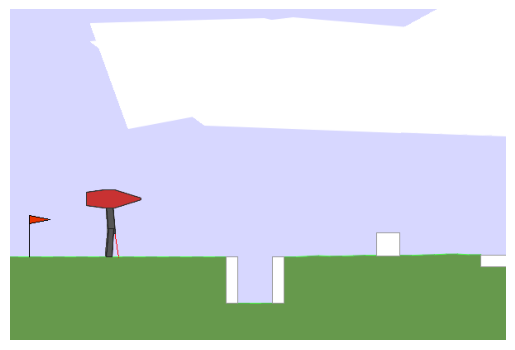

In [20]:
# make env
# only attempt hardcore when your agent has solved the non-hardcore version
env = rld.make("rldurham/Walker", render_mode="rgb_array", hardcore=config.hardcore)

# get statistics, logs, and videos
video_prefix = "nchw73-agent-hardcore-video" if config.hardcore else "nchw73-agent-video"
video_prefix = f"{timestamp}_" + video_prefix # mark video with date/time to be mateched to run (remove later!)
env = rld.Recorder(
    env,
    smoothing=10,                       # track rolling averages (useful for plotting)
    video=True,                         # enable recording videos
    video_folder="videos",              # folder for videos
    video_prefix=video_prefix,          # prefix for videos
    logs=True,                          # keep logs
)

rld.check_device() # training on CPU recommended

env.video = False # switch video recording off (only switch on every x episodes as this is slow)

# environment info
discrete_act, discrete_obs, act_dim, state_dim = rld.env_info(env, print_out=True)

# render start image
env.reset(seed=seed)
rld.render(env)

**Training**

In [21]:
# in the submission please use seed_everything with seed 42 for verification
seed, state, info = rld.seed_everything(seed, env)

# track statistics for plotting
tracker = rld.InfoTracker()

replay_buffer = EREReplayBuffer(state_dim, act_dim, config.annealing_steps, config.buffer_size, config.eta0, config.cmin)

actor = Actor(state_dim, act_dim, config.actor_hidden_dims).to(DEVICE)

critic = Critic(state_dim, act_dim, config.n_quantiles, config.n_mini_critics, config.mini_critic_hidden_dims).to(DEVICE)
critic_target = copy.deepcopy(critic)

dreamer = None # init as none
if config.use_dreamer:
    dreamer = DreamerAgent(state_dim, act_dim, config.hidden_dim, 
        config.window_size, config.num_layers, config.num_heads, config.dropout_prob, config.dreamer_lr).to(DEVICE)

target_entropy = -np.prod(env.action_space.shape).item() # target entropy heuristic (= −dim(A) as in D2RL paper)
grad_step_class = GradientStep(
    actor=actor, critic=critic, critic_target=critic_target,
    discount=config.discount, tau=config.tau,
    actor_lr=config.actor_lr, critic_lr=config.critic_lr, alpha_lr=config.alpha_lr,
    n_quantiles=config.n_quantiles, n_mini_critics=config.n_mini_critics,
    top_quantiles_to_drop_per_net=config.top_quantiles_to_drop_per_net,
    target_entropy=target_entropy,
    )

actor.train()

total_steps = 0
memory_ptr = 0 # marks boundary between new and old data in the replay buffer
train_set, test_set = None, None
recent_rewards= []
ep_timesteps_dreamer = ep_reward_dreamer = dreamer_eps = 0
last_dreamer_test_loss = 0.0 # track dreamer test loss

success_ep = config.max_episodes # minimise i such that r_mean @ episode i >= target_score


Seed set to 42


In [22]:
# load from checkpoint
if loaded_checkpoint:
    actor.load_state_dict(loaded_checkpoint['actor_state_dict'])
    critic.load_state_dict(loaded_checkpoint['critic_state_dict'])
    critic_target.load_state_dict(loaded_checkpoint['critic_target_state_dict']) # Load target critic state too
    grad_step_class.actor_optimizer.load_state_dict(loaded_checkpoint['actor_optimizer_state_dict'])
    grad_step_class.critic_optimizer.load_state_dict(loaded_checkpoint['critic_optimizer_state_dict'])
    grad_step_class.alpha_optimizer.load_state_dict(loaded_checkpoint['alpha_optimizer_state_dict'])
    grad_step_class.log_alpha.data = loaded_checkpoint['log_alpha'] # Load log_alpha value

    if config.use_dreamer and dreamer is not None and 'dreamer_state_dict' in loaded_checkpoint:
        dreamer.load_state_dict(loaded_checkpoint['dreamer_state_dict'])
        dreamer.optimizer.load_state_dict(loaded_checkpoint['dreamer_optimizer_state_dict'])
        train_set = loaded_checkpoint.get('train_set') # Use .get for optional keys
        test_set = loaded_checkpoint.get('test_set')

    # Load replay buffer state
    replay_buffer.ptr = loaded_checkpoint['replay_buffer_ptr']
    replay_buffer.size = loaded_checkpoint['replay_buffer_size']
    replay_buffer.rollover = loaded_checkpoint['replay_buffer_rollover']
    # If loading buffer data separately:
    # buffer_data = loaded_checkpoint.get('replay_buffer_data')
    # if buffer_data is not None:
    #     replay_buffer.state[:replay_buffer.size] = buffer_data['state'][:replay_buffer.size]
    #     replay_buffer.action[:replay_buffer.size] = buffer_data['action'][:replay_buffer.size]
    #     replay_buffer.next_state[:replay_buffer.size] = buffer_data['next_state'][:replay_buffer.size]
    #     replay_buffer.reward[:replay_buffer.size] = buffer_data['reward'][:replay_buffer.size]
    #     replay_buffer.not_done[:replay_buffer.size] = buffer_data['not_done'][:replay_buffer.size]
    # else: # If buffer data wasn't loaded, reset buffer state variables that depend on it
    #     print("Warning: Replay buffer data not loaded, buffer content might be inconsistent.")
    #     # Decide how to handle this - maybe clear the buffer?
    #     replay_buffer.ptr = 0
    #     replay_buffer.size = 0
    #     replay_buffer.rollover = False
    # If saving buffer state directly in checkpoint (simpler, but larger file):
    replay_buffer.state = loaded_checkpoint['replay_buffer_state']
    replay_buffer.action = loaded_checkpoint['replay_buffer_action']
    replay_buffer.next_state = loaded_checkpoint['replay_buffer_next_state']
    replay_buffer.reward = loaded_checkpoint['replay_buffer_reward']
    replay_buffer.not_done = loaded_checkpoint['replay_buffer_not_done']


    total_steps = loaded_checkpoint['total_steps']
    memory_ptr = loaded_checkpoint['memory_ptr']
    recent_rewards = loaded_checkpoint['recent_rewards']
    success_ep = loaded_checkpoint['success_ep']
    if 'tracker_info' in loaded_checkpoint:
        tracker.info = loaded_checkpoint['tracker_info']

    # Clean up memory
    del loaded_checkpoint
    # if 'buffer_data' in locals(): del buffer_data
    if DEVICE == torch.device("cuda"):
        torch.cuda.empty_cache()


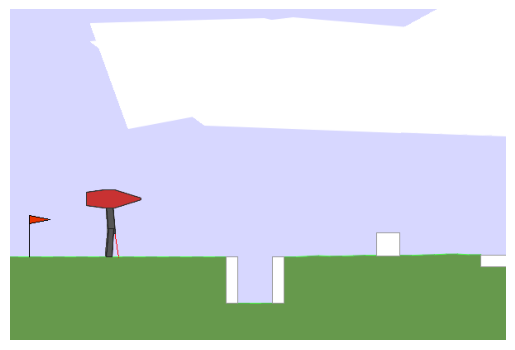

Ep: 1 | Timesteps: 74 | Reward: -116.373 | Total Steps: 74 | Dreamer: False


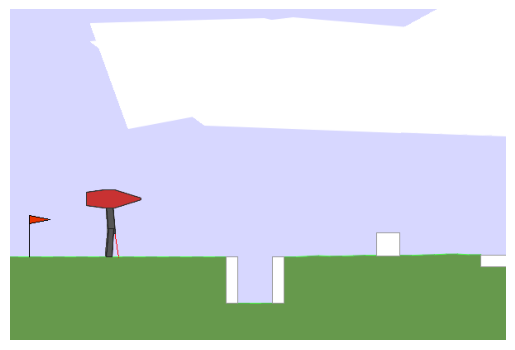

Ep: 2 | Timesteps: 70 | Reward: -114.310 | Total Steps: 1.4e+02 | Dreamer: False


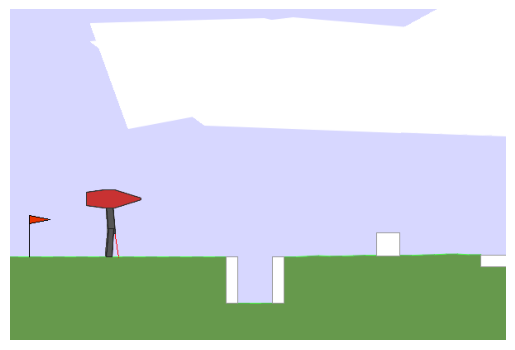

Ep: 3 | Timesteps: 74 | Reward: -117.437 | Total Steps: 2.2e+02 | Dreamer: False


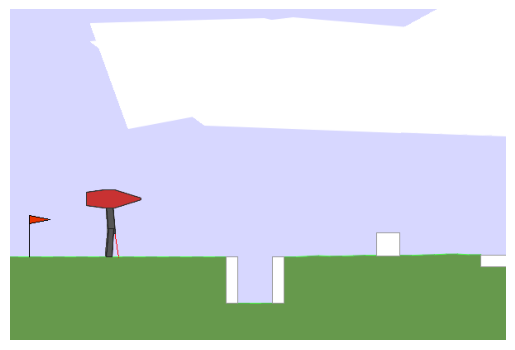

KeyboardInterrupt: 

In [ ]:
# training loop
episode = start_episode # =1 by default or whatever was in the checkpoint
while episode <= config.max_episodes: # index from 1
    # recording statistics and video can be switched on and off (video recording is slow!)
    if is_recording and episode >= ep_start_rec:
        env.info = episode % video_interval == 0   # track every x episodes (usually tracking every episode is fine)
        env.video = episode % video_interval == 0  # record videos every x episodes (set BEFORE calling reset!)

    # reset for new episode
    state, info = env.reset(seed=seed)
    state = state.astype(np.float32) # float32 for mps

    # sample real env
    ep_timesteps, ep_reward, input_buffer, info = train_on_environment(
        actor, env, grad_step_class, replay_buffer, config.max_timesteps, state,
        config.batch_size, total_steps, config.window_size,
        use_intrinsic_reward=(config.use_dreamer and episode > config.episode_threshold), # use intrinsic reward if dreamer active
        last_dreamer_test_loss=last_dreamer_test_loss,
        intrinsic_r_scale=config.intrinsic_reward_scale,
        )

    total_steps += ep_timesteps
    tracker.track(info) # track statistics for plotting

    # update train/test sets for dreamer (add new eps and trim to window size)
    train_set, test_set = gen_test_train_seq(
        replay_buffer, train_set, test_set, config.train_split, config.window_size, config.step_size, memory_ptr)

    # train dreamer after ep_thresh and if the input buffer has enough data to fill context window
    if config.use_dreamer and episode >= config.episode_threshold and input_buffer.shape[0] == config.window_size:
        # train and assess the dreamer every train_frequency
        if episode % config.dreamer_train_frequency == 0:
            dreamer.train_dreamer(train_set, config.dreamer_train_epochs, config.batch_size_dreamer)

        # truncate the training set to control train time performance
        if test_set.shape[0] > config.max_size:
            train_set = train_set[-config.max_size:]

        print(f'Size of train set: {train_set.shape[0]}, test set: {test_set.shape[0]}')
        
        # evaluate the dreamer's performance & decide num of training steps for dreamer
        dreamer_avg_loss = dreamer.test_dreamer(test_set, config.batch_size_dreamer)
        dreamer_eps = get_dreamer_eps(dreamer_avg_loss, config.score_threshold)

        # train on dreamer if its accurate enough
        if dreamer_eps > 0:
            print(f'Dreamer active for {dreamer_eps} iterations')
            ep_timesteps_dreamer = ep_reward_dreamer = 0
            for dep in range(dreamer_eps):
                print(f'Dreamer ep: {dep+1}')

                # initialise dreamer states with the input sequence
                # input buffer = state, action, next_state, reward, done NOTE - this is different to order learned in training
                dreamer.states = input_buffer[:, :state_dim]
                dreamer.actions = input_buffer[:-1, state_dim:state_dim+act_dim]
                dreamer.rewards = input_buffer[:-1, -2-state_dim].unsqueeze(1)
                dreamer.dones = input_buffer[:-1, -1-state_dim].unsqueeze(1)

                # sample from dreamer environment (ignore input buffer and info)
                if config.auto_horizon:
                    imagination_horizon = min(config.imagination_horizon, ep_timesteps)
                else:
                    imagination_horizon = config.imagination_horizon
                _td, _rd, _, _ = train_on_environment(
                    actor, dreamer, grad_step_class, replay_buffer,
                    imagination_horizon, # number of timesteps to run the dreamer for
                    dreamer.states[-1].cpu().numpy(), # use last state from dreamer TODO why?
                    config.batch_size, total_steps, config.window_size,
                    use_intrinsic_reward=False)

                ep_timesteps_dreamer += _td
                ep_reward_dreamer += _rd

    memory_ptr = replay_buffer.ptr # update the memory pointer to the current position in the buffer

    print(f"Ep: {episode} | Timesteps: {ep_timesteps} | Reward: {ep_reward:.3f} | Total Steps: {total_steps:.2g} | Dreamer: {dreamer_eps > 0}")
    if config.use_dreamer and dreamer_eps > 0:
        print(f"\t Dreamer Eps: {dreamer_eps} | Dreamer Avg Reward: {ep_reward_dreamer/dreamer_eps:.3f} | Dreamer Avg Timesteps: {ep_timesteps_dreamer/dreamer_eps:.3g}")

    # Log metrics to W&B
    log_dict = {
        "Total Steps": total_steps,
        "Episode Timesteps": ep_timesteps,
    }

    # log tracked statistics
    if 'recorder' in info: # if we have info available
        log_dict["TrackedInfo/r_mean_"] = info['recorder']['r_mean_'] # r is extrinsic only
        log_dict["TrackedInfo/r_std_"] = info['recorder']['r_std_']
        log_dict["TrackedInfo/r_sum"] = info['recorder']['r_sum']

        if info['recorder']['r_mean_'] >= config.target_score: # update success_ep
            success_ep = min(success_ep, episode)
            print(f'target score reached at episode {success_ep}!')
        log_dict["Episodes to Reach Target"] = success_ep

    if config.use_dreamer:
        log_dict["Dreamer Average Loss"] = dreamer_avg_loss if 'dreamer_avg_loss' in locals() else None # Only log if calculated
        log_dict["Dreamer Episodes Run"] = dreamer_eps
        if dreamer_eps > 0:
            log_dict["Dreamer Average Reward"] = ep_reward_dreamer / dreamer_eps
            log_dict["Dreamer Average Timesteps"] = ep_timesteps_dreamer / dreamer_eps

    wandb.log(log_dict, step=episode) # log metrics each ep

    recent_rewards.append(ep_reward)

    # plot tracked statistics (on real env)
    if episode % plot_interval == 0:
        # save as well (show=False returns it but doesnt display)
        if save_fig and info : # check info isnt {} (i.e. not None)
            fig, _ = tracker.plot(show=False, r_mean_=True, r_std_=True, r_sum=dict(linestyle=':', marker='x'))
            wandb.log({"Coursework Plot": wandb.Image(fig)}, step=episode) # Log the figure directly to W&B
            # fig.savefig(f'./tracker_{run_name}.png', bbox_inches = 'tight')
            plt.close(fig) # Close the figure to free memory
        # show by default
        tracker.plot(r_mean_=True, r_std_=True, r_sum=dict(linestyle=':', marker='x'))

    # checkpoint
    if use_checkpointing and episode % checkpoint_interval == 0:
        checkpoint_state = {
            'episode': episode,
            'total_steps': total_steps,
            'actor_state_dict': actor.state_dict(),
            'critic_state_dict': critic.state_dict(),
            'critic_target_state_dict': critic_target.state_dict(), # Save target critic state
            'actor_optimizer_state_dict': grad_step_class.actor_optimizer.state_dict(),
            'critic_optimizer_state_dict': grad_step_class.critic_optimizer.state_dict(),
            'alpha_optimizer_state_dict': grad_step_class.alpha_optimizer.state_dict(),
            'log_alpha': grad_step_class.log_alpha.data, # Save the tensor data
            'replay_buffer_ptr': replay_buffer.ptr,
            'replay_buffer_size': replay_buffer.size,
            'replay_buffer_rollover': replay_buffer.rollover,
            # Save buffer content directly (simpler, larger file)
            'replay_buffer_state': replay_buffer.state,
            'replay_buffer_action': replay_buffer.action,
            'replay_buffer_next_state': replay_buffer.next_state,
            'replay_buffer_reward': replay_buffer.reward,
            'replay_buffer_not_done': replay_buffer.not_done,
            'memory_ptr': memory_ptr,
            'recent_rewards': recent_rewards,
            'success_ep': success_ep,
            'wandb_run_id': wandb.run.id,
            # 'config': config, # Optional: save config if needed
            'tracker_info': tracker.info # save tracker history
        }
        if config.use_dreamer and dreamer is not None:
            checkpoint_state['dreamer_state_dict'] = dreamer.state_dict()
            checkpoint_state['dreamer_optimizer_state_dict'] = dreamer.optimizer.state_dict()
            checkpoint_state['train_set'] = train_set # Save dreamer datasets
            checkpoint_state['test_set'] = test_set

        save_checkpoint(checkpoint_state)

    episode += 1

    # break condition - stop if we consistently meet target score
    if len(recent_rewards) >= config.len_r_list or success_ep < config.max_episodes:
        current_avg = np.array(recent_rewards).mean()
        print(f'Current progress: {current_avg:.3f} / {config.target_score}')
        if current_avg >= config.target_score or success_ep < config.max_episodes: # quit when we've got good enough performance
            print('Completed environment!')
            break
        recent_rewards = recent_rewards[-config.len_r_list+1:] # discard oldest on list (keep most recent 99)

# don't forget to close environment (e.g. triggers last video save)
env.close()

# write log file
if config.hardcore:
    filename = f"[{run_name}]_" + "nchw73-agent-hardcore-log.txt"
else:
    filename = f"[{run_name}]_" + "nchw73-agent-log.txt"
env.write_log(folder="logs", file=filename)

wandb.finish() # finish wandb run
